# Data Science Academy

# Projeto de Análise de Dados com Linguagem Python

## Projeto 6 - Regras de Associação e Market Basket Analysis (MBA)

### Pacotes Python Usados no Projeto

In [1]:
!pip install -q efficient_apriori

In [2]:
# Imports
import numpy as np
import pandas as pd
import efficient_apriori
import matplotlib.pyplot as plt
from datetime import datetime
from efficient_apriori import apriori
import warnings
warnings.filterwarnings('ignore')

In [3]:
%reload_ext watermark
%watermark -a "Leonardo da Silva Neves"

Author: Leonardo da Silva Neves



### Carregando os Dados

In [4]:
# Carregando os Dados
dados_departamentos = pd.read_csv('Cap10/departamentos.csv')
dados_corredores = pd.read_csv('Cap10/corredores.csv')
dados_produtos = pd.read_csv('Cap10/produtos.csv')
dados_pedidos = pd.read_csv('Cap10/pedidos.csv')
dados_transacoes = pd.read_csv('Cap10/transacoes.csv') 


### Análise Exploratória

#### Detalhes do Tamanho de Cada Dataset via Programação

In [5]:
# Total de registros por dataset
conta_arrays = np.array([['dados_departamentos', len(dados_departamentos), dados_departamentos.shape[1]],
                       ['dados_corredores', len(dados_corredores), dados_corredores.shape[1]],
                       ['dados_produtos', len(dados_pedidos), dados_pedidos.shape[1]],
                       ['dados_transacoes', len(dados_transacoes), dados_transacoes.shape[1]]])

In [6]:
# Converte o array em dataframe
contagem = pd.DataFrame(conta_arrays, columns = ['Arquivo', 'Total de Registros', 'Total_Colunas'])

In [7]:
print(contagem)

               Arquivo Total de Registros Total_Colunas
0  dados_departamentos                 21             2
1     dados_corredores                134             2
2       dados_produtos            3421083             7
3     dados_transacoes           32434489             4


In [8]:
# Tabela de Departamentos
dados_departamentos.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [9]:
dados_corredores.shape

(134, 2)

In [10]:
# Tabela de Corredores
dados_corredores.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
# Tabela de Produtos
dados_produtos.shape

(49688, 4)

In [12]:
dados_produtos.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
dados_pedidos.shape

(3421083, 7)

In [14]:
# Tabela Pedidos
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [15]:
dados_transacoes.shape

(32434489, 4)

In [16]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Verificando Valores Ausentes

In [17]:
dados_departamentos.isna().sum()

department_id    0
department       0
dtype: int64

In [18]:
dados_corredores.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [19]:
dados_produtos.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [20]:
dados_pedidos.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [21]:
dados_transacoes.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### *Reorganização dos dados*

#### Merge das tabelas

#### O merge só é possível quando existe um relacionamento entre os dados.

Como estratégia escolhi carregar mesclar uma tabela de cada vez.

In [22]:
%%time
dados_transacoes = dados_transacoes.merge(dados_pedidos, on = 'order_id', how = 'left')


CPU times: total: 9.48 s
Wall time: 10.2 s


In [23]:
%%time
dados_transacoes = dados_transacoes.merge(dados_produtos, on = 'product_id', how = 'left')
#dados_transacoes = dados_transacoes.merge(dados_corredores, on = 'aisle_id', how = 'left')
#dados_transacoes = dados_transacoes.merge(dados_departamentos, on = 'department_id', how = 'left')

CPU times: total: 17.4 s
Wall time: 19.8 s


In [24]:
%%time
dados_transacoes = dados_transacoes.merge(dados_corredores, on = 'aisle_id', how = 'left')
#dados_transacoes = dados_transacoes.merge(dados_departamentos, on = 'aisle_id', how = 'left')

CPU times: total: 19.7 s
Wall time: 22.2 s


In [25]:
%%time
dados_transacoes = dados_transacoes.merge(dados_departamentos, on = 'department_id', how = 'left')

CPU times: total: 7.75 s
Wall time: 8.42 s


In [26]:
# Checando o número de colunas.
len(dados_transacoes.columns.to_list())

15

In [27]:
# Visualização da tabela completa depois do .merge()
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [28]:
%%time
dados_transacoes.isna().sum()

CPU times: total: 5.81 s
Wall time: 5.87 s


order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [29]:
%%time
dados_transacoes.isnull().sum() / len(dados_transacoes) * 100

CPU times: total: 4.83 s
Wall time: 4.88 s


order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

Vamos a variável days_since_prior_order por duas razões:

1- O percentual de valores é apenas de 6.4%.

2- Não usaremos a variável com o algorítmo MBA.

Agrupando os dados e preparando o dataset com todas as transações. Usaremos os dados para aplicar o algorítmo a priori mais tarde.

In [30]:
%%time
df = pd.DataFrame(dados_transacoes.groupby('order_id')['product_id'])

CPU times: total: 3min 10s
Wall time: 3min 16s


In [31]:
df.shape

(3214874, 2)

In [32]:
df.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [33]:
# Lista
prod = []

In [34]:
%%time
for i in range(len(df[0])):
    prod.append(list(df.iloc[i][1]))

CPU times: total: 2min 48s
Wall time: 2min 53s


In [35]:
# Preparar o dataframe
transacoes = pd.DataFrame({'Id_Pedido':df[0], 'Produtos': prod})

In [36]:
transacoes.head(10)

,Id_Pedido,Produtos
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


## Análise Estatística Descritiva

### 1 -  Qual o número de pedidos mais frequênte entre os usuários?

In [37]:
# Visualizando uma amostra aleatória de dados
dados_pedidos.sample(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
758521,3348349,45639,prior,45,4,11,10.0
1389271,3204868,83498,prior,7,6,17,30.0
100004,386543,6045,prior,7,6,15,2.0
507540,2069345,30622,prior,4,6,12,30.0
3172129,630928,191265,prior,4,3,11,30.0
1004923,2388487,60396,prior,49,5,17,17.0
3210932,1520358,193586,prior,11,5,18,5.0
3181540,1136556,191838,prior,10,3,9,10.0
1502644,432350,90300,prior,2,2,10,14.0
775133,1135966,46576,prior,2,6,13,20.0


In [38]:
# Agrupar os dados por usuário agregando pelo maior valor de order_number
contagem_maxima_pedido = dados_pedidos.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
contagem_maxima_pedido.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


Compreendendo o código anterior:

order.groupby("user_id"): Este comando agrupa o DataFrame order pela coluna "user_id". Isso significa que todas as linhas com o mesmo valor em user_id são consideradas juntas em um grupo. A operação de agrupamento é preparatória para realizar alguma operação de agregação dentro de cada grupo.

['order_number'].aggregate(np.max): Depois de agrupar os dados por user_id, selecionamos a coluna 'oreder_number' desses grupos. Então, usamos a função aggregate com np.max (que é a função de máximo do NumPy) para calcular o maior valore de 'order_number' dentro de cada grupo. Em outras palavras, para cada usuário, estamos encontrando o maior número de pedidos.

.reset_index(): Este método é usado para resetar o indice do DataFrame. Quando realizamos uma função de agrupamento, o pandas transforma as colunas pelas quais agrupamos (neste caso, user_id) em índices no novo DataFrame. Usar reset_index() move user_id de volta para uma coluna regular e cria um novo índice numérico padrão.

In [39]:
# Frequência de cada valor de número de pedidos
contagem_maxima_pedido = contagem_maxima_pedido.order_number.value_counts()
contagem_maxima_pedido.head()

order_number
4    23986
5    19590
6    16165
7    13850
8    11700
Name: count, dtype: int64

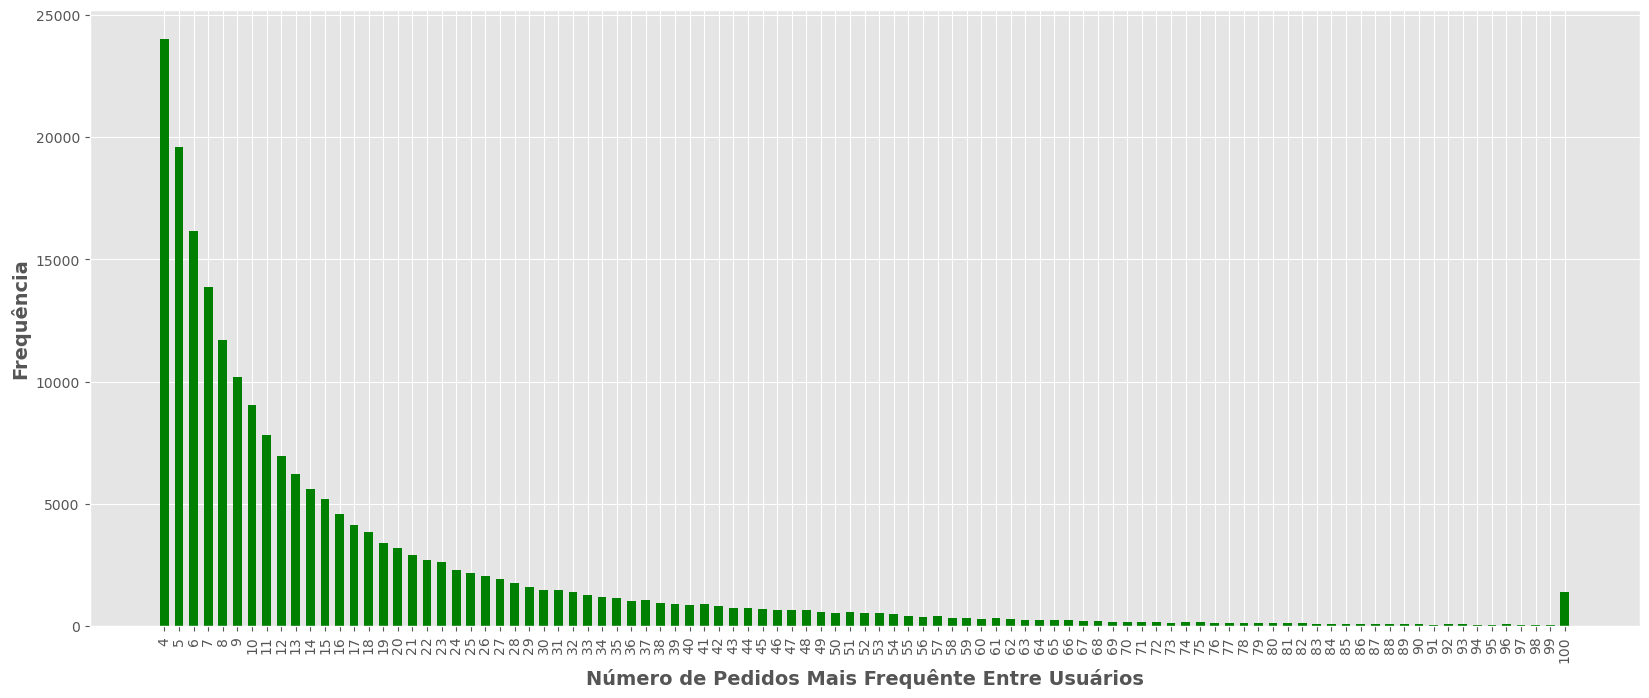

In [40]:
# Plotando os dados no gráfico.
plt.style.use('ggplot')
plt.figure(figsize=(20,8))
plt.bar(contagem_maxima_pedido.index, contagem_maxima_pedido.values, color = 'green', width = 0.6)
plt.xticks(contagem_maxima_pedido.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')
plt.xlabel('Número de Pedidos Mais Frequênte Entre Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

### 2 - Qual dia da semana tem o maior número de pedidos?

In [41]:
# (dow - day of the week)
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [42]:
# Contagem de frequência (ocorrência) de cada valor de order_dow
dados_pedidos.order_dow.value_counts()

order_dow
0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: count, dtype: int64

Preparando x e y para o gráfico no formato de lista Python.

In [43]:
# Índice para os dias da semana
x = [0, 1, 2, 3, 4, 5, 6]

In [44]:
# Frequência de pedidos pelo índice (dia da semana)
y = dados_pedidos['order_dow'].value_counts().sort_index().tolist()
y

[600905, 587478, 467260, 436972, 426339, 453368, 448761]

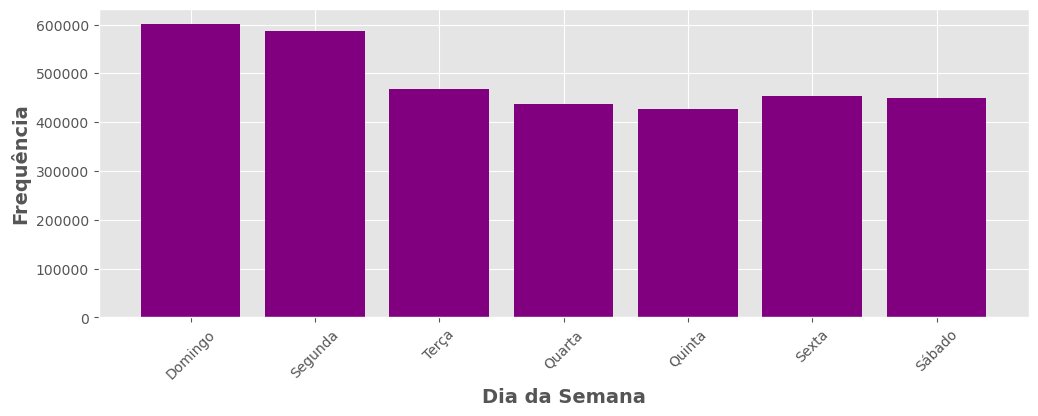

In [45]:
#Plot
plt.figure(figsize=(12,4))
plt.bar(x, y, color = 'purple')
plt.xlabel('Dia da Semana', fontsize=14, fontweight='bold')
plt.ylabel('Frequência', fontsize=14, fontweight='bold')
plt.xticks(x, ['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 45)
plt.show()

### 3 - Qual hora do dia tem o maior número de pedidos?

In [46]:
dados_pedidos.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


#### Solução 1 com recursos da linguagem Python

In [47]:
# Frequência de pedidos pela hora do dia
x1 = list(range(0,24))
print(x1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [48]:
# Frequência de pedidos pela hora do dia
y1 = []
for i in range(0,24):
    y1.append(dados_pedidos[dados_pedidos['order_hour_of_day']==i].shape[0])
print(y1)

[22758, 12398, 7539, 5474, 5527, 9569, 30529, 91868, 178201, 257812, 288418, 284728, 272841, 277999, 283042, 283639, 272553, 228795, 182912, 140569, 104292, 78109, 61468, 40043]


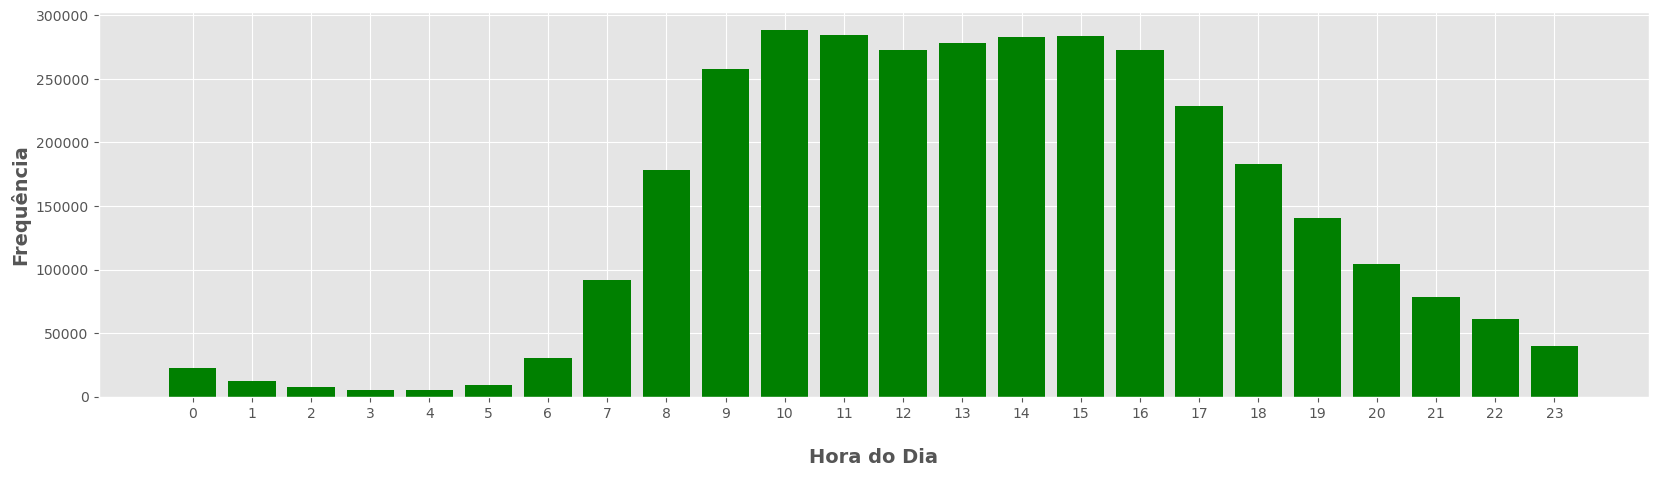

In [49]:
#Plot
plt.figure(figsize = (20,5))
plt.bar(x1, y1, color = 'green')
plt.xticks(np.arange(0,24,1))
plt.xlabel('\nHora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize= 14, fontweight = 'bold')
plt.show()

#### Solução 2 com Recursos do Pandas

In [50]:
# Agrupar por hora do dia e contar os pedidos
frequencia_por_hora = dados_pedidos.groupby('order_hour_of_day').size()
frequencia_por_hora.head()

order_hour_of_day
0    22758
1    12398
2     7539
3     5474
4     5527
dtype: int64

In [51]:
# Extrair horas e contagens para a lista x e y
x2 = frequencia_por_hora.index.tolist()
y2 = frequencia_por_hora.values.tolist()

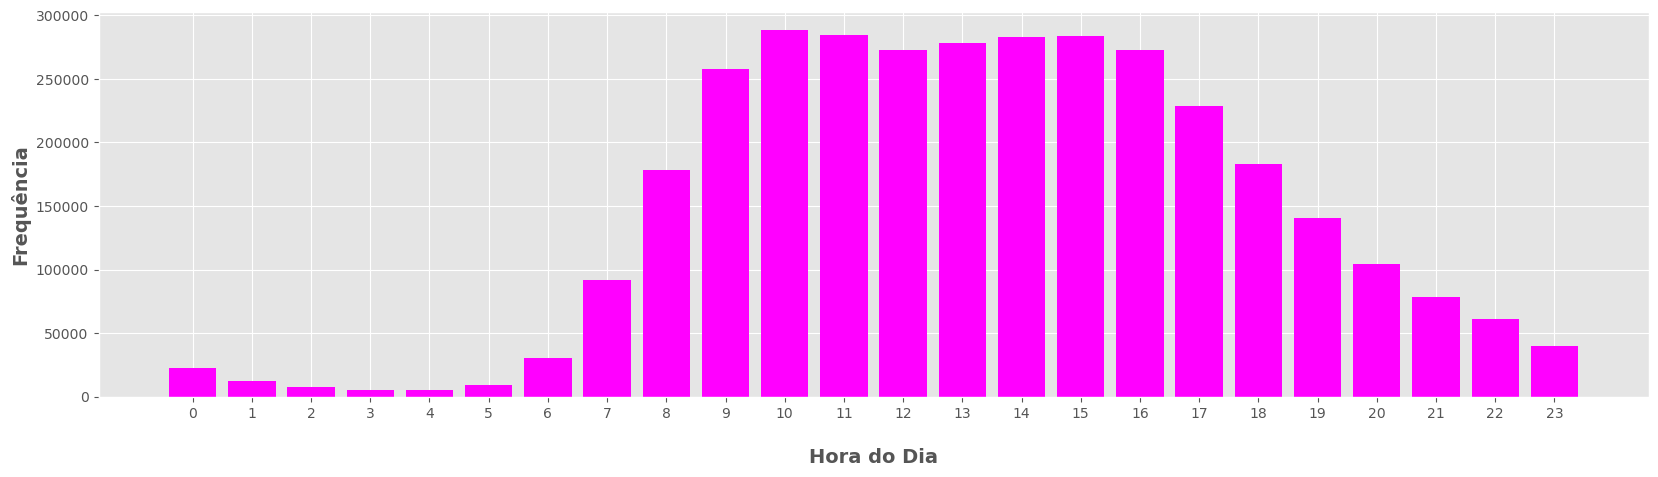

In [52]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x2, y2, color = 'magenta')
plt.xticks(np.arange(0,24,1))
plt.xlabel('\nHora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

#### 4 - Qual departamento tem o maior número de pedidos?

In [53]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [54]:
# Contagem de pedidos por departamento
contagem_departamento = dados_transacoes['department'].value_counts()
contagem_departamento.head()

department
produce       9479291
dairy eggs    5414016
snacks        2887550
beverages     2690129
frozen        2236432
Name: count, dtype: int64

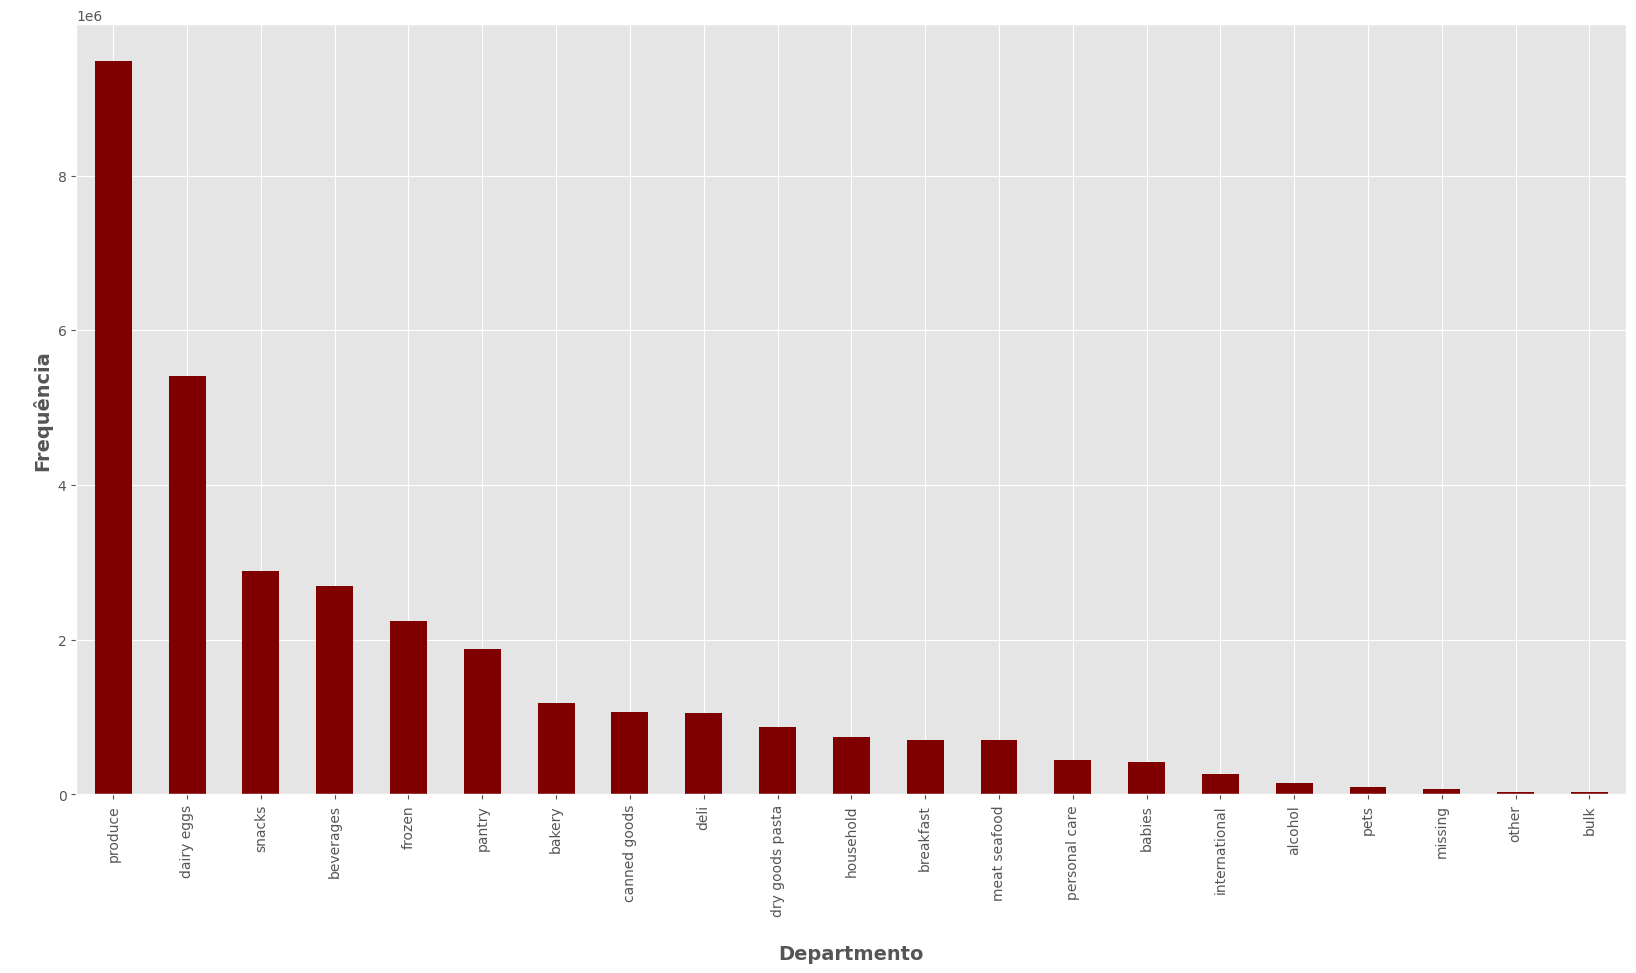

In [55]:
# Plot
fig = plt.figure(figsize = (20,10))
contagem_departamento.plot(kind = "bar", color = "maroon")
plt.xticks(rotation = 90)
plt.xlabel('\nDepartmento', fontsize= 14, fontweight = 'bold')
plt.ylabel('\nFrequência', fontsize= 14, fontweight = 'bold')
plt.show()

A solução acima funciona pois a tebela dados_transacoes possui o nome dos departamentos. Se fosse necessário buscar o nome em outra tabela, a solução seria diferente:

In [56]:
# Unindo dados transacoes com dados_produtos
# suffixes é usado para diferenciar as colunas com mesmo nome
transacoes_produtos = pd.merge(dados_transacoes, dados_produtos, on='product_id', suffixes=('', '_produto'))
transacoes_produtos.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department,product_name_produto,aisle_id_produto,department_id_produto
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry,Garlic Powder,104,13
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry,Coconut Butter,19,13
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry,Natural Sweetener,17,13


In [57]:
# Agora, vamos usar a coluna 'department_id' apropriada para o próximo merge
# Garantido que estamos usando 'department_id' do DataFrame dados_produtos
transacoes_departamentos = pd.merge(transacoes_produtos, dados_departamentos, on='department_id')
transacoes_departamentos.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department_x,product_name_produto,aisle_id_produto,department_id_produto,department_y
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,Organic Egg Whites,86,16,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce,Michigan Organic Kale,83,4,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry,Garlic Powder,104,13,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry,Coconut Butter,19,13,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry,Natural Sweetener,17,13,pantry


In [58]:
# Contar as transações por departamento
contagem_departamentos = transacoes_departamentos['department_x'].value_counts()
contagem_departamentos.head()

department_x
produce       9479291
dairy eggs    5414016
snacks        2887550
beverages     2690129
frozen        2236432
Name: count, dtype: int64

In [59]:
# Encontrar o departamento com maior número de pedidos
departamento_mais_pedidos = contagem_departamentos.idxmax()

In [60]:
print(departamento_mais_pedidos)

produce


### 5 - Quais os 20 principais corredores por frequência de pedidos?

In [61]:
dados_transacoes.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [62]:
# Os vinte principais corredores e sua frequência de pedidos
contagem = dados_transacoes['aisle'].value_counts()

In [63]:
# Realizando o filtro dos 20 primeiros elementos da série 'contagem'.
contagem[0:20]

aisle
fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
refrigerated                      575881
frozen produce                    522654
ice cream ice                     498425
crackers                          458838
energy granola bars               456386
eggs                              452134
lunch meat                        395130
frozen meals                      390299
baby food formula                 382456
fresh herbs                       377741
Name: count, dtype: int64

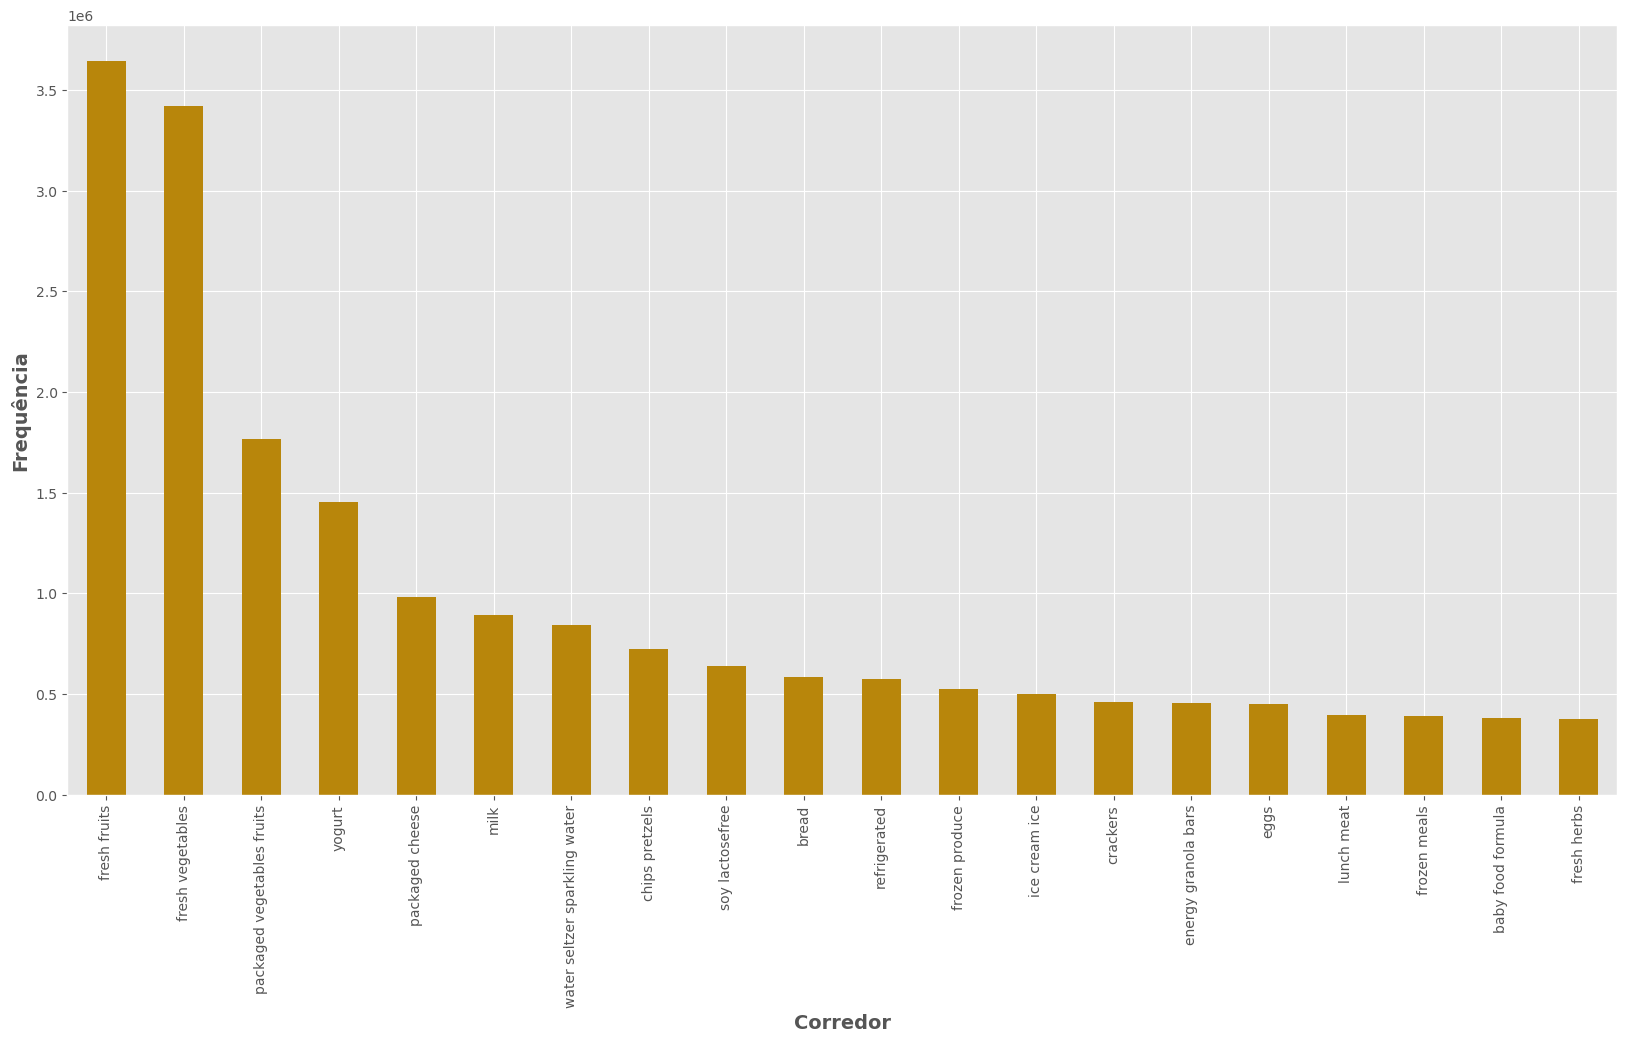

In [64]:
# Plot da série
fig = plt.figure(figsize=(20,10))
contagem[0:20].plot(kind='bar', color='darkgoldenrod')
plt.xticks(rotation=90)
plt.xlabel('Corredor', fontsize=14, fontweight='bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

Mesmo caso do item 4. Por acaso os dados estão todos na tabela dados_transacoes. Se não estivessem, teríamos que fazer merge como o exemplo abaixo:

In [65]:
# Contar a frequência de cada produto em dados_transações
frequencia_produtos = dados_transacoes['product_id'].value_counts()

In [66]:
# Criar um dicionário para mapear product_id para aisle_id
produto_para_corredor = dict(zip(dados_produtos['product_id'], dados_produtos['aisle_id']))

In [67]:
# Criar um dicionário para mapear aisle_id para o nome do corredor
id_para_nome_corredor = dict(zip(dados_corredores['aisle_id'], dados_corredores['aisle']))

In [68]:
# Calcular a frequência de cada corredor
frequencia_corredores = {}
for produto, freq in frequencia_produtos.items():
    corredor_id = produto_para_corredor.get(produto)
    if corredor_id:
        corredor_nome = id_para_nome_corredor.get(corredor_id, "Corredor Desconhecido")
        frequencia_corredores[corredor_nome] = frequencia_corredores.get(corredor_nome, 0) + freq

In [69]:
# Ordenar os corredores por frequências e pegar os 20 pricipais
principais_corredores = sorted(frequencia_corredores.items(), key=lambda x: x[1], reverse=True)[:20]

In [70]:
# Exibindo os 20 principais corredores
for corredor, freq in principais_corredores:
    print(f"Corredor: {corredor}, Frequência: {freq}")

Corredor: fresh fruits, Frequência: 3642188
Corredor: fresh vegetables, Frequência: 3418021
Corredor: packaged vegetables fruits, Frequência: 1765313
Corredor: yogurt, Frequência: 1452343
Corredor: packaged cheese, Frequência: 979763
Corredor: milk, Frequência: 891015
Corredor: water seltzer sparkling water, Frequência: 841533
Corredor: chips pretzels, Frequência: 722470
Corredor: soy lactosefree, Frequência: 638253
Corredor: bread, Frequência: 584834
Corredor: refrigerated, Frequência: 575881
Corredor: frozen produce, Frequência: 522654
Corredor: ice cream ice, Frequência: 498425
Corredor: crackers, Frequência: 458838
Corredor: energy granola bars, Frequência: 456386
Corredor: eggs, Frequência: 452134
Corredor: lunch meat, Frequência: 395130
Corredor: frozen meals, Frequência: 390299
Corredor: baby food formula, Frequência: 382456
Corredor: fresh herbs, Frequência: 377741


### 6 - Quais os  20 principais produtos por frequência de pedidos?

In [71]:
# Os 20 principais produtos por frequência de pedido
contagem_produto = dados_transacoes['product_name'].value_counts()

In [72]:
contagem_produto[0:20]

product_name
Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: count, dtype: int64

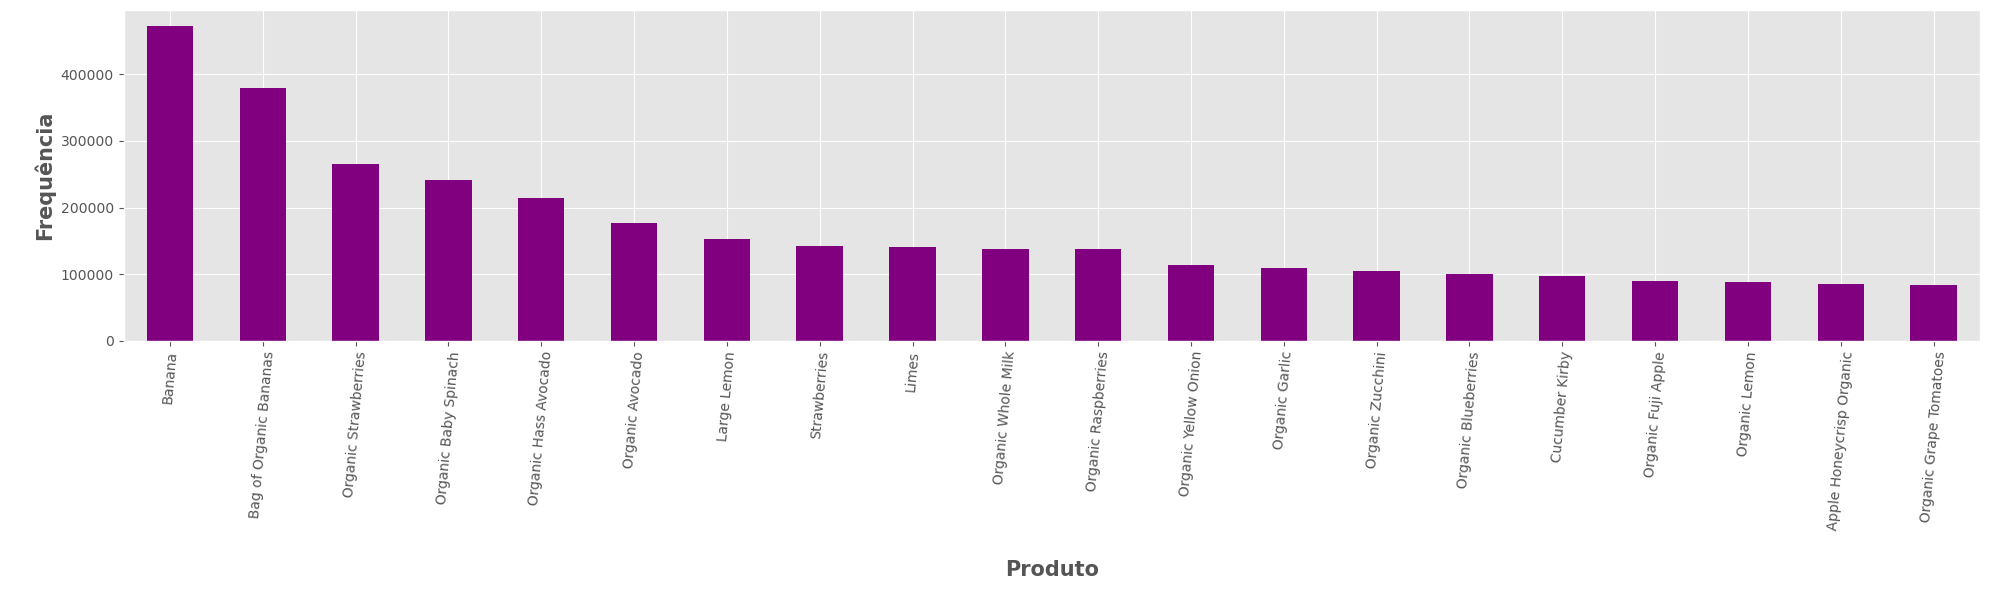

In [73]:
# Plot
fig = plt.figure(figsize=(20,6))
contagem_produto[0:20].plot(kind='bar', color='purple')
plt.xticks(rotation = 85)
plt.xlabel('\nProduto', fontsize = 15, fontweight = 'bold')
plt.ylabel('\nFrequência', fontsize = 15, fontweight = 'bold')
plt.tight_layout()
plt.show()

### 7 - Análise de novos pedidos semelhantes a pedidos anteriores (reorder)
Agruparemos os dados para obter contagem e soma

In [75]:
%%time
df_temp1 = dados_transacoes.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total', 'sum':'reorders'})
df_temp1 = df_temp1.sort_values('total', ascending = False).reset_index()

CPU times: total: 7.17 s
Wall time: 7.68 s


O código a cima está usando a biblionteca Pandas para manipular um DaraFrame dados_transacoes.

O que cada parte do código faz:

dados_transacoes.groupby("product_name")["reordered"]: Isso agrupo o DataFrame dados_transacoes pelo valor da coluna "product_name" e depois seleciona a coluna "reordered" para futuras operações.

.agg(['count', 'sum']): Isso aplica duas funções de agregação, count e sum, à coluna "reordered" para cada grupo (cada produto único). A função count conta o número de vezes que cada produto aparece no DataFrame (ou seja, a frequência do produto) e a função sum soma os valores da coluna "reordered"
para cada grupo, que indica a quantidade de vezes que o produto foi reordenado.

.rename(columns = {'count':'total', 'sum':'reorders'}): Isso renomeia as colunas resultantes da agregação para "total" (anteriormente "count") e "reorders" (anteriormente "sum"), para tornar os nomes das colunas mais descritivos.

df_temp1 = ...: O resultado das operações acima é atribuido a um novo DataFrame chamado df_temp1.

df_temp1.sort_values('total', ascending = False): Isso ordena o DataFrame df_temp1 pela coluna "total" em ordem decrescente. Isso significa que os produtos com as maiores frequências (ou seja, os mais comuns) aparecerão primeiro.

.reset_index(): Isso redefine o índice do DataFrame resultante, de modo que o índice seja uma sequência numérica simples (começando em 0). isso é útil após a ordenação, pois garante que o índice reflita a nova ordem dos dados.

In [76]:
# Preparar as listas com os 20 top registros (para nõa poluir o gráfico)
labels = list(df_temp1.product_name[0:20])
reorder = list(df_temp1.reorders[0:20])
total = list(df_temp1.total[0:20])

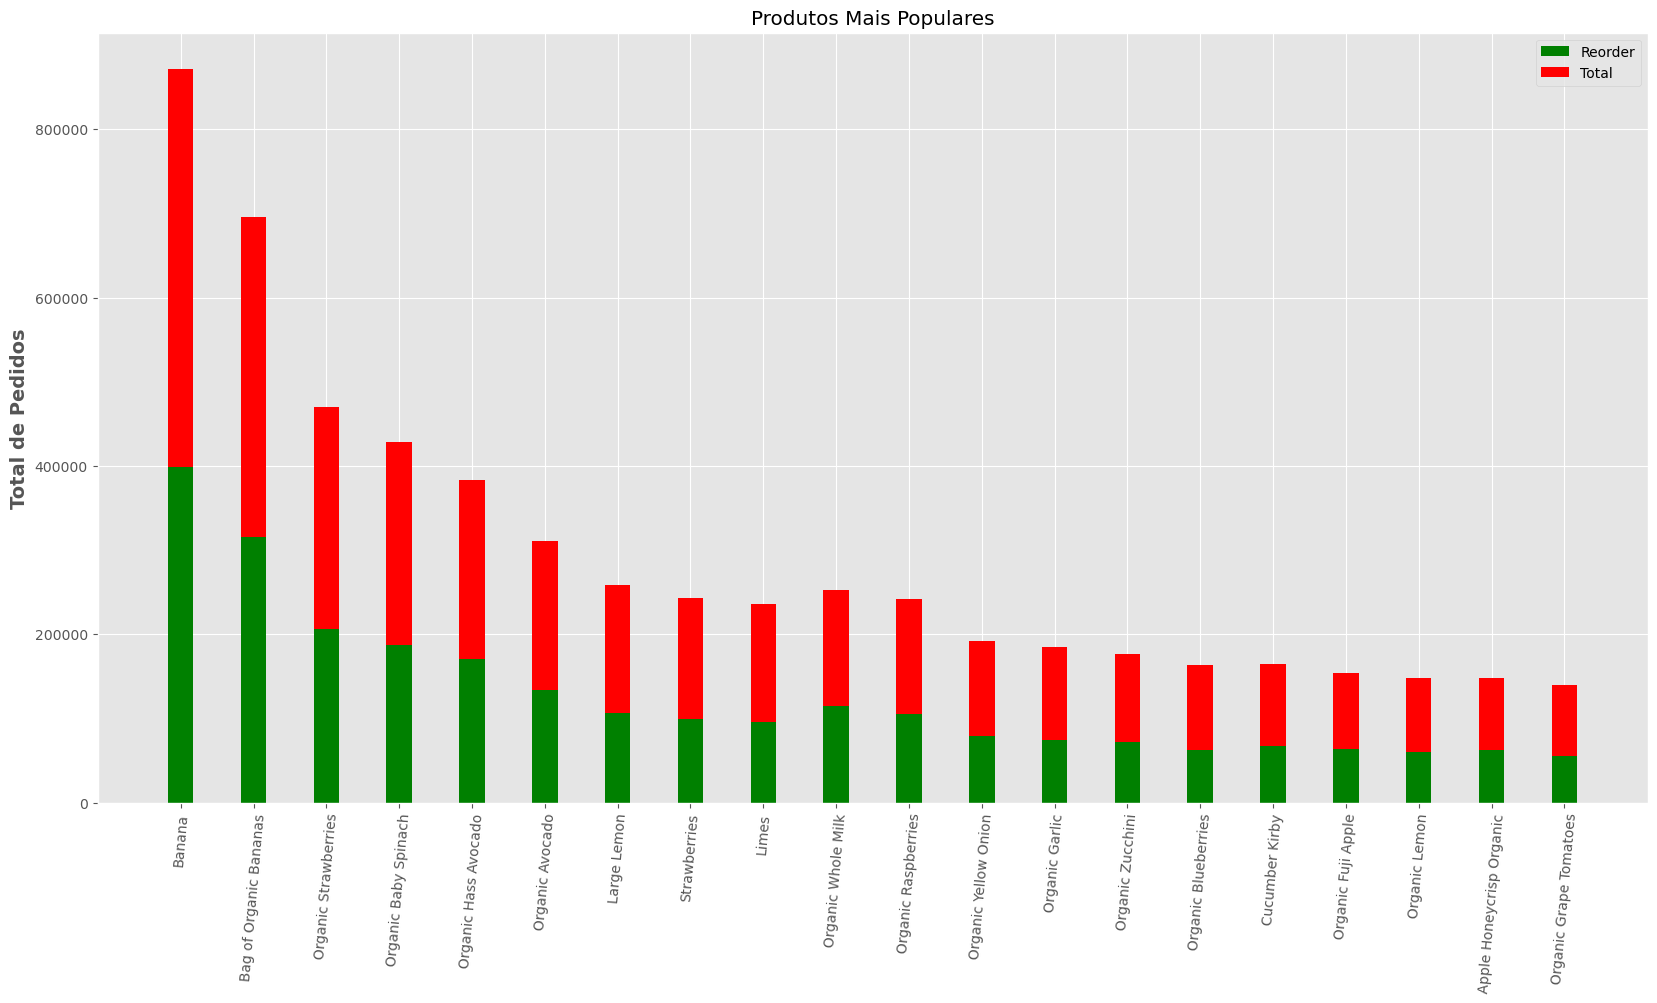

In [78]:
# Plot
width = 0.35
fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares")
plt.xticks(rotation = 85)
plt.show()

### 8 - Análise de reorder por departamento ao longo do tempo

In [79]:
# Agrupando os dados por departamento e reorder
df_temp2 = dados_transacoes.groupby(["department"])["reordered"].aggregate("mean").reset_index()
df_temp2.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


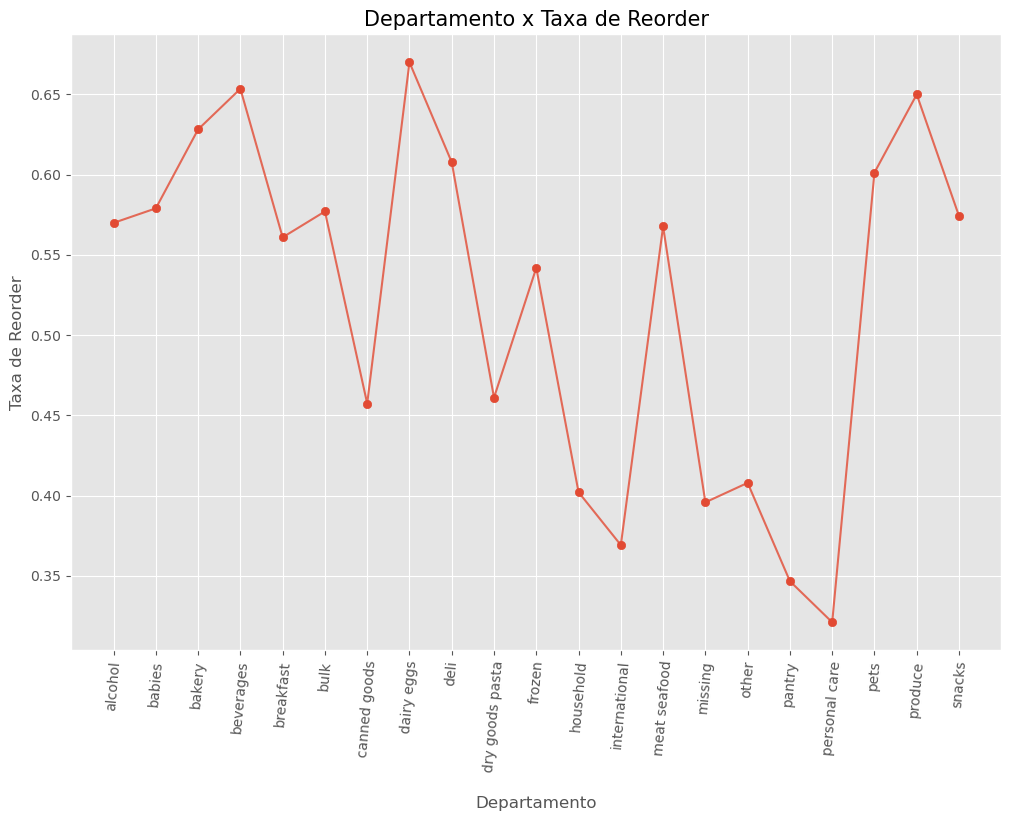

In [80]:
# Plot
plt.figure(figsize = (12, 8))
plt.plot(list(df_temp2['department']), df_temp2['reordered'].values, alpha=0.8)
plt.scatter(list(df_temp2['department']), df_temp2['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('\nDepartamento', fontsize = 12)
plt.title("Departamento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 85)
plt.show()